In [1]:
import numpy as np
from astropy.io import fits,ascii
from astropy import units as u
import pandas as pd
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy.stats import mode
import emcee
import corner
from sklearn.neighbors import KernelDensity

Coordinates of Swift J0243+6124 from VLA radio detection (van den Eijnden+ 2017, ATel....)

In [3]:
c = SkyCoord('02 43 40.4373 +61 26 03.713', unit=(u.hourangle, u.deg))

In [ ]:
#Search for the source in a 10 arcsec radius
ga = cone_search(c.ra.deg, c.dec.deg, 10/3600.,
                 table='gaiadr2.gaia_source')

Setting up the likelihood model, as suggested in Lindegren+2018

$\ln[P(\bar{\omega}|r,\sigma_{\omega})] = \frac{1}{2\sigma_{\omega}^2}(\bar{\omega} - \bar{\omega}_{zp} - \frac{1}{r})^2 - \ln(\sqrt{2\pi}\sigma_{\omega})$

In [59]:
def lnlike(theta, y, yerr):
    distance = theta
    model = 1. / distance
    w_zp = -0.029 # zero point, Lindegren+2018
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-w_zp-model)**2*inv_sigma2 \
            - np.log(np.sqrt(2*np.pi)*yerr)))

We use the exponential volume prior, from Bailer-Jones 2015

$P(r)=\frac{1}{2L^3}r^2e^{-r/L}$, for $r>0$

where L=1.257 kpc.

In [60]:
def lnprior(theta):
    distance = theta
    L = 1.257 #kpc
    if  distance > 0:
        prior = 1./(2 * L**3) * distance**2 * np.exp(-distance/L)
        return np.log(prior)
    return -np.inf 

Set-up the full unnormalised posterior distribution

In [61]:
def lnprob(theta, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr)

The function that performs the sampling of the posterior 
distribution with EMCEE (Foreman-Mackay+ 2013) http://adsabs.harvard.edu/abs/2013PASP..125..306F

In [62]:
def gaia_errors(par,par_error,samp_out=True, burn_in=500, num_chains=2000):
    ndim, nwalkers = 1, 60
    pos = [1./par + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(par,par_error),threads=1)
    sampler.run_mcmc(pos, num_chains)
    samples_exp = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

    q05 = corner.quantile(samples_exp,.05)
    q50 = corner.quantile(samples_exp,.50)
    q95 = corner.quantile(samples_exp,.95)
    if samp_out:
        return q05[0], q50[0], q95[0],samples_exp
    else:
        return q05[0], q50[0], q95[0]

In [63]:
parallax, error = 0.0952,0.0302
frac = error/parallax

print("sig/parallax={:.3f}".format(error/parallax))
#print("SNR={:.3f}".format((parallax+0.029)/error))
print("")
print("d_naive={:.3f} ± {:.3f} kpc".format(1/parallax,error/parallax**2))



sig/parallax=0.317

d_naive=10.504 ± 3.332 kpc


We calculate the 5, 50 and 95 percentile

In [64]:
q05,q50,q95,samples_exp = gaia_errors(parallax, error,
                          burn_in=500, num_chains=4000)

In [65]:
print(" 5 percentile = {:.2f}\n \
50 percentile = {:.2f}\n \
95 percentile = {:.2f}".format(q05,q50,q95))

 5 percentile = 5.49
 50 percentile = 7.22
 95 percentile = 10.16


In [66]:
print("d={:.2f} + {:.2f} - {:.2f} kpc".format(q50,q95-q50,q50-q05))
q_01 = corner.quantile(samples_exp,1-.99)
print("Distance lower limit 1%={:.2f} kpc".format(q_01[0]))

d=7.22 + 2.94 - 1.73 kpc
Distance lower limit 1%=4.98 kpc


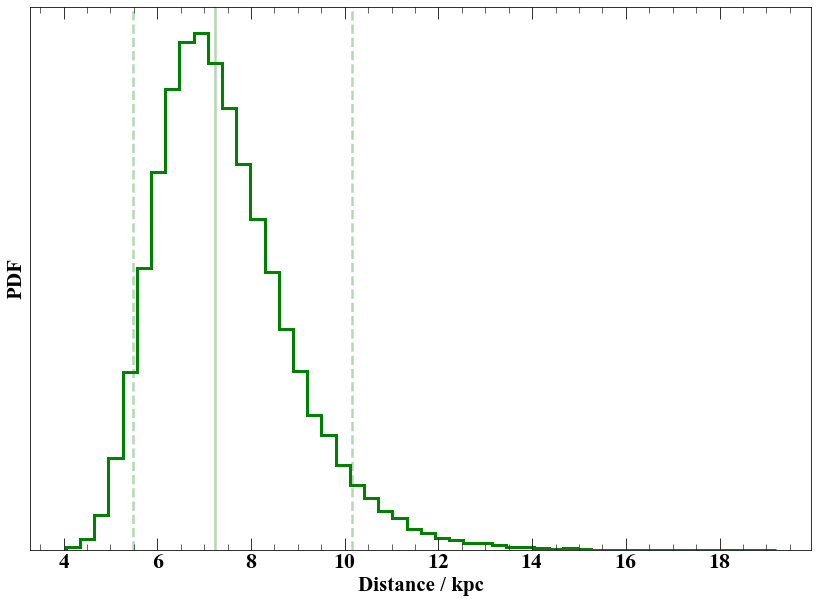

In [67]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
X_plot = np.linspace(0,25.,10000)[:, np.newaxis]
a = plt.hist(samples_exp,bins=50,color='green',lw=3,histtype='step')

plt.axvline(x=corner.quantile(samples_exp,.05),ls='--',color='green',alpha=0.3,lw=2.5)
plt.axvline(x=corner.quantile(samples_exp,.5),ls='-',color='green',alpha=0.3,lw=2.5)
plt.axvline(x=corner.quantile(samples_exp,.95),ls='--',color='green',alpha=0.3,lw=2.5)

ax.set_yticklabels([])
ax.set_yticks([])
plt.xlabel("Distance / kpc")
plt.ylabel("PDF")

Same thing but for a unifrom prior with a $r_{lim}=50$ kpc

In [54]:
def lnlike(theta, y, yerr):
    distance = theta
    model = 1. / distance
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr)

def lnprior(theta):
    distance = theta
    #r_lim=100 kpc
    if  0 < distance <50:
        prior = 1./50.
        return prior
    return -np.inf 

def gaia_errors(par,par_error,samp_out=True,num_chains=2000,burn_in=500):
    ndim, nwalkers = 1, 60
    pos = [1./par + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(par,par_error),threads=1)
    sampler.run_mcmc(pos, num_chains)
    samples_exp = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    

    q05 = corner.quantile(samples_exp,.05)
    q50 = corner.quantile(samples_exp,.50)
    q95 = corner.quantile(samples_exp,.95)
    if samp_out:
        return q05[0], q50[0], q95[0],samples_exp
    
    else:
        return q05[0], q50[0], q95[0]

In [55]:
q05,q50,q95,samples_uni = gaia_errors(parallax, error,
                          burn_in=500, num_chains=4000)

In [56]:
print(" 5 percentile = {:.2f}\n \
50 percentile = {:.2f}\n \
95 percentile = {:.2f}".format(q05,q50,q95))

 5 percentile = 7.98
 50 percentile = 14.18
 95 percentile = 38.07


In [57]:
print("d={:.2f} + {:.2f} - {:.2f} kpc".format(q50,q95-q50,q50-q05))
q_01 = corner.quantile(samples_uni,1-.99)
print("Distance lower limit 1%={:.2f} kpc".format(q_01[0]))

d=14.18 + 23.89 - 6.20 kpc
Distance lower limit 1%=6.78 kpc


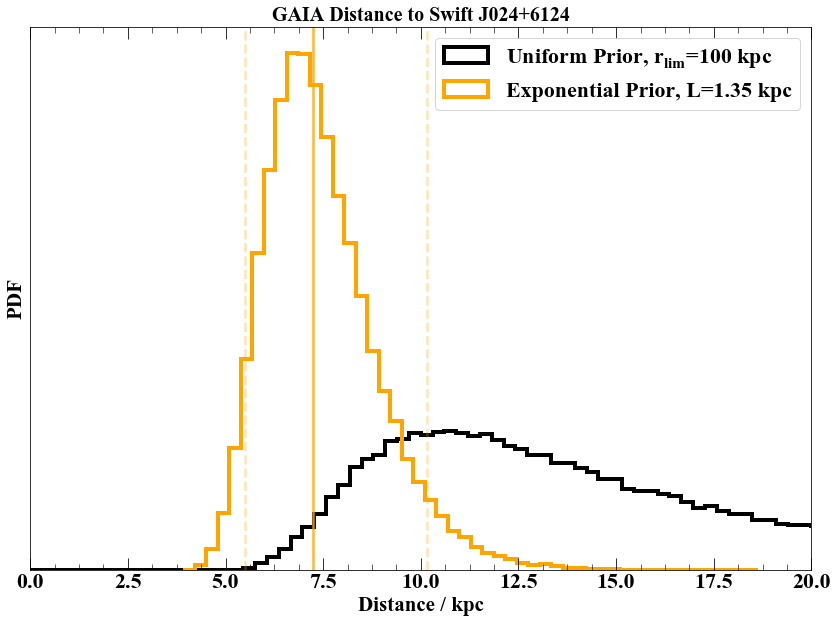

In [58]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
plt.title('GAIA Distance to Swift J024+6124')
a = plt.hist(samples_uni,bins=np.linspace(0,30,100),color='k',lw=4,histtype='step',
            label=r'Uniform Prior, $r_{lim}$=100 kpc')

a = plt.hist(samples_exp,bins=50,color='orange',lw=4,histtype='step',
             label='Exponential Prior, L=1.35 kpc')

plt.axvline(x=corner.quantile(samples_exp,.5),ls='-',
            color='orange',alpha=0.8,lw=2.5)

plt.axvline(x=corner.quantile(samples_exp,.05),ls='--',
            color='orange',alpha=0.3,lw=2.5)
plt.axvline(x=corner.quantile(samples_exp,.95),ls='--',
            color='orange',alpha=0.3,lw=2.5)
ax.set_yticklabels([])
plt.xlabel('Distance / kpc')
plt.ylabel('PDF')
ax.set_yticklabels([])
ax.set_yticks([])
plt.xlim(0,20.000)
lg = plt.legend(fontsize=22,loc=1)
#plt.savefig("gaia_distance.pdf",dpi=300)